In [1]:
# %%
import ast
import json
import random
import glob

from os.path import join
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import numpy as np
import os
import wandb

In [2]:
milestones_path = "/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones"

In [3]:
list(Path(milestones_path).iterdir())

[PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones/checkpoint_000097656_425000960.pth'),
 PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones/checkpoint_000061036_275005440.pth'),
 PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones/checkpoint_000103760_450002944.pth'),
 PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones/checkpoint_000018312_100007936.pth'),
 PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-critic-lr-groups_jnve_3/train_dir/default_experiment/checkpoint_p0/milestones/checkpoint_000109864_475004928.pth'),
 PosixPath('/home/bartek/2024-05-29-monk-appo-ks-t-layernorm-pretrain-

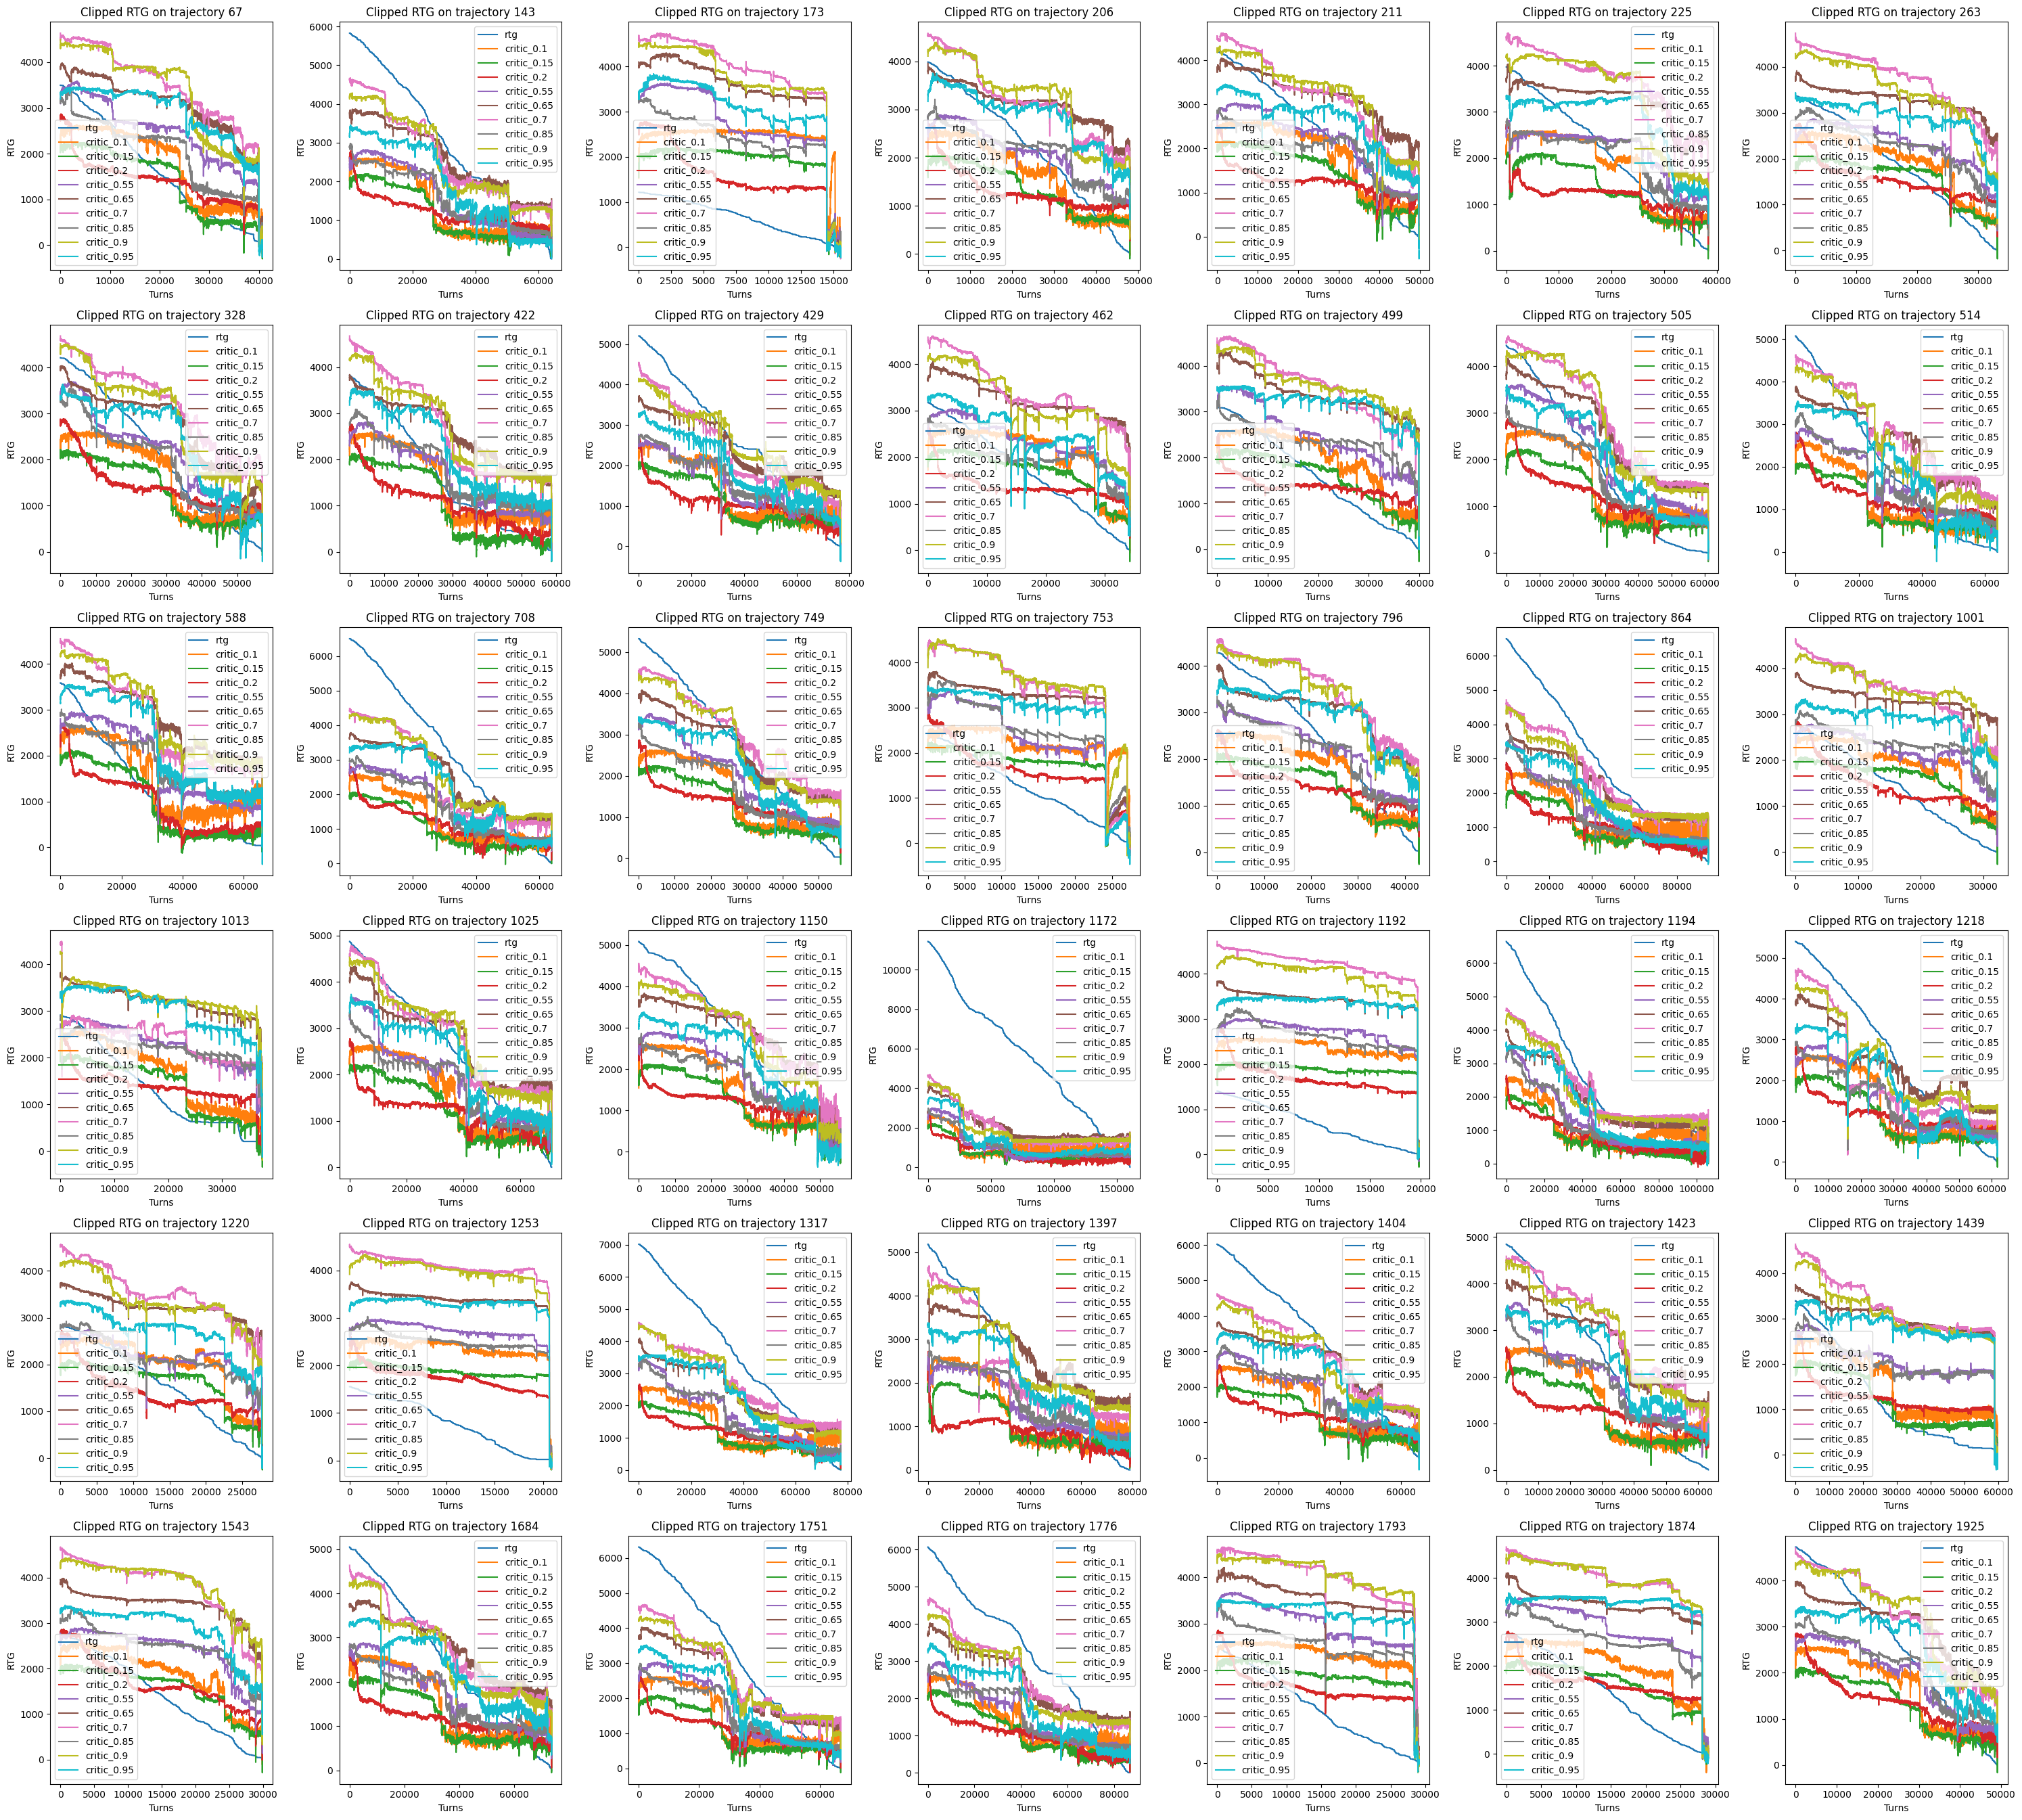

In [19]:
fig, axes = plt.subplots(6, 7, figsize=(30, 27))
axes = axes.flatten()

i = 0
for e, checkpoint_path in enumerate(sorted(Path(milestones_path).iterdir())):
    root = Path(checkpoint_path.stem) / "artifacts"
    train_progress = (np.round((int(str(root).split('_')[-1]) // 25000000)) * 25000000) / 500000000
    
    if not root.exists():
        continue    
        
    rewards = torch.load(root / "rewards.pt")
    clipped_rewards = torch.load(root / "clipped_rewards.pt")
    timestamps = torch.load(root / "timestamps.pt")
    denormalized_values = torch.load(root / "denormalized_values.pt")
        
    cumsum_rewards = dict(map(lambda kv: (kv[0], np.cumsum(kv[1].cpu().numpy()[::-1])[::-1]), rewards.items()))
    cumsum_clipped_rewards = dict(map(lambda kv: (kv[0], np.cumsum(kv[1].cpu().numpy()[::-1])[::-1]), clipped_rewards.items()))
        
    sum_rewards = dict(map(lambda kv: (kv[0], torch.sum(kv[1]).item()), rewards.items()))
    sum_clipped_rewards = dict(map(lambda kv: (kv[0], torch.sum(kv[1]).item()), clipped_rewards.items()))
    
    keys = list(cumsum_clipped_rewards.keys())

    for key, ax in zip(keys, axes):
        if i == 0:
            ax.plot(cumsum_clipped_rewards[key], label=f"rtg")
        ax.plot(denormalized_values[key].cpu().numpy(), label=f"critic_{train_progress}")
    
        ax.legend()
        ax.set_ylabel("RTG")
        ax.set_xlabel("Turns")

        ax.set_title(f"Clipped RTG on trajectory {key}")
    i += 1
    fig.tight_layout()

In [4]:
rewards = torch.load("artifacts/rewards.pt")
clipped_rewards = torch.load("artifacts/clipped_rewards.pt")
timestamps = torch.load("artifacts/timestamps.pt")
denormalized_values = torch.load("artifacts/denormalized_values.pt")

In [5]:
cumsum_rewards = dict(map(lambda kv: (kv[0], np.cumsum(kv[1].cpu().numpy()[::-1])[::-1]), rewards.items()))
cumsum_clipped_rewards = dict(map(lambda kv: (kv[0], np.cumsum(kv[1].cpu().numpy()[::-1])[::-1]), clipped_rewards.items()))

In [6]:
sum_rewards = dict(map(lambda kv: (kv[0], torch.sum(kv[1]).item()), rewards.items()))
sum_clipped_rewards = dict(map(lambda kv: (kv[0], torch.sum(kv[1]).item()), clipped_rewards.items()))

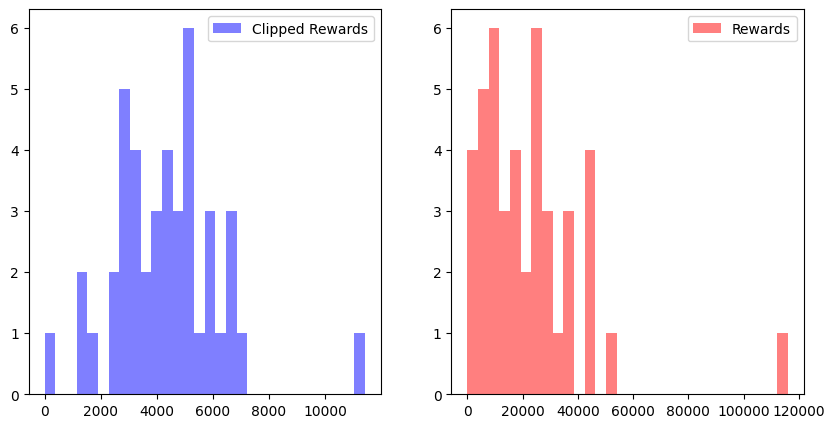

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

axes[0].hist(sum_clipped_rewards.values(), bins=30, alpha=0.5, color='blue', label='Clipped Rewards')
axes[1].hist(sum_rewards.values(), bins=30, alpha=0.5, color='red', label='Rewards')
axes[0].legend()
axes[1].legend()